## Introduction

Word2Vec is a popular algorithm used for generating dense vector representations of words in large corpora using unsupervised learning. The resulting vectors have been shown to capture semantic relationships between the corresponding words and are used extensively for many downstream natural language processing (NLP) tasks like sentiment analysis, named entity recognition and machine translation.  

SageMaker BlazingText which provides efficient implementations of Word2Vec on

- single CPU instance
- single instance with multiple GPUs - P2 or P3 instances

In this notebook, we demonstrate how BlazingText can be used for comparative training of word2vec using a single CPU and a single GPU instances.

## Setup

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance, training, and hosting. If you don't specify a bucket, SageMaker SDK will create a default bucket following a pre-defined naming convention in the same region. 
- The IAM role ARN used to give SageMaker access to your data. It can be fetched using the **get_execution_role** method from sagemaker python SDK.

In [15]:
!git clone https://github.com/hghodrati/wikifil.git

Cloning into 'wikifil'...
remote: Enumerating objects: 12, done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 12
Unpacking objects: 100% (12/12), done.


In [16]:
import os
if not os.path.isfile('text9'):
  !wget -c http://mattmahoney.net/dc/enwik9.zip
  !unzip enwik9.zip
  

In [18]:
!perl wikifil/wikifil.pl enwik9 > text9

In [19]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import json

sess = sagemaker.Session()

role = get_execution_role()
print(role) # This is the role that SageMaker would use to leverage AWS resources (S3, CloudWatch) on your behalf

bucket = sess.default_bucket() # Replace with your own bucket name if needed
print(bucket)
prefix = 'sagemaker/DEMO-blazingtext-text8' #Replace with the prefix under which you want to store the data if needed

arn:aws:iam::349934754982:role/service-role/AmazonSageMaker-ExecutionRole-20190424T004453
sagemaker-ap-southeast-1-349934754982


### Data Ingestion

Next, we download a dataset from the web on which we want to train the word vectors. BlazingText expects a single preprocessed text file with space separated tokens and each line of the file should contain a single sentence.

In this example, let us train the vectors on [text9](http://mattmahoney.net/dc/textdata.html) dataset, which is a small (already preprocessed) version of Wikipedia dump.  

After the data downloading and uncompressing is complete, we need to upload it to S3 so that it can be consumed by SageMaker to execute training jobs. We'll use Python SDK to upload these two files to the bucket and prefix location that we have set above.

In [20]:
train_channel = prefix + '/train'

sess.upload_data(path='text9', bucket=bucket, key_prefix=train_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)

Next we need to setup an output location at S3, where the model artifact will be dumped. These artifacts are also the output of the algorithm's training job.

In [21]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)

## Training Setup
Now that we are done with all the setup that is needed, we are ready to train our object detector. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

In [22]:
region_name = boto3.Session().region_name

In [23]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 475088953585.dkr.ecr.ap-southeast-1.amazonaws.com/blazingtext:latest (ap-southeast-1)


## Training the BlazingText model for generating word vectors

Similar to the original implementation of [Word2Vec](https://arxiv.org/pdf/1301.3781.pdf), SageMaker BlazingText provides an efficient implementation of the continuous bag-of-words (CBOW) and skip-gram architectures using Negative Sampling, on CPUs and additionally on GPU[s]. The GPU implementation uses highly optimized CUDA kernels. To learn more, please refer to [*BlazingText: Scaling and Accelerating Word2Vec using Multiple GPUs*](https://dl.acm.org/citation.cfm?doid=3146347.3146354). BlazingText also supports learning of subword embeddings with CBOW and skip-gram modes. This enables BlazingText to generate vectors for out-of-vocabulary (OOV) words, as demonstrated in this [notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/blazingtext_word2vec_subwords_text8/blazingtext_word2vec_subwords_text8.ipynb).





Now, let's define the resource configuration and hyperparameters to train word vectors on *text9* dataset, using "skipgram" mode on a single p3.2xlarge instances.


## Run word2vec with a single GPU powered instance

In [24]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.p3.2xlarge',
                                         train_volume_size = 5,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

Please refer to [algorithm documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext_hyperparameters.html) for the complete list of hyperparameters.

In [25]:
bt_model.set_hyperparameters(mode="skipgram",
                             epochs=20,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=10,
                             vector_dim=300,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram

Now that the hyper-parameters are setup, let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our data channels. These objects are then put in a simple dictionary, which the algorithm consumes.

In [26]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data}

We have our `Estimator` object, we have set the hyper-parameters for this object and we have our data channels linked with the algorithm. The only  remaining thing to do is to train the algorithm. The following command will train the algorithm. Training the algorithm involves a few steps. Firstly, the instance that we requested while creating the `Estimator` classes is provisioned and is setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take some time, depending on the size of the data. Therefore it might be a few minutes before we start getting training logs for our training jobs. The data logs will also print out `Spearman's Rho` on some pre-selected validation datasets after the training job has executed. This metric is a proxy for the quality of the algorithm. 

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as `output_path` in the estimator.

In [27]:
bt_model.fit(inputs=data_channels, logs=True)

2019-05-08 13:51:54 Starting - Starting the training job...
2019-05-08 13:51:56 Starting - Launching requested ML instances......
2019-05-08 13:53:03 Starting - Preparing the instances for training......
2019-05-08 13:54:23 Downloading - Downloading input data
2019-05-08 13:54:23 Training - Downloading the training image..
Arguments: train
[05/08/2019 13:54:29 WARNING 140525156124480] Loggers have already been setup.
[05/08/2019 13:54:29 WARNING 140525156124480] Loggers have already been setup.
[05/08/2019 13:54:29 INFO 140525156124480] nvidia-smi took: 0.0503199100494 secs to identify 1 gpus
[05/08/2019 13:54:29 INFO 140525156124480] Running BlazingText on singe GPU using skipgram
[05/08/2019 13:54:29 INFO 140525156124480] 2 files found in train channel. Using /opt/ml/input/data/train/text9 for training...
[05/08/2019 13:54:29 INFO 140525156124480] Processing /opt/ml/input/data/train/text9 . File size: 680 MB
Read 10M words
Read 20M words
Read 30M words
Read 40M words
Read 50M words
R

## Run word2vec with a single CPU instance

We run word2vec with the same configuration as before except now we use a standard CPU m4.4xlarge instance.

In [32]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.4xlarge',
                                         train_volume_size = 5,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [33]:
bt_model.set_hyperparameters(mode="skipgram",
                             epochs=20,
                             min_count=5,
                             sampling_threshold=0.0001,
                             learning_rate=0.05,
                             window_size=10,
                             vector_dim=300,
                             negative_samples=5,
                             batch_size=11, #  = (2*window_size + 1) (Preferred. Used only if mode is batch_skipgram)
                             evaluation=True,# Perform similarity evaluation on WS-353 dataset at the end of training
                             subwords=False) # Subword embedding learning is not supported by batch_skipgram

In [34]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data}

In [35]:
bt_model.fit(inputs=data_channels, logs=True)

2019-05-08 14:23:57 Starting - Starting the training job...
2019-05-08 14:23:58 Starting - Launching requested ML instances......
2019-05-08 14:25:06 Starting - Preparing the instances for training...
2019-05-08 14:25:41 Downloading - Downloading input data..
Arguments: train
[05/08/2019 14:26:05 WARNING 140255244523328] Loggers have already been setup.
[05/08/2019 14:26:05 WARNING 140255244523328] Loggers have already been setup.
[05/08/2019 14:26:05 INFO 140255244523328] nvidia-smi took: 0.0251519680023 secs to identify 0 gpus
[05/08/2019 14:26:05 INFO 140255244523328] Running single machine CPU BlazingText training using skipgram mode.
[05/08/2019 14:26:05 INFO 140255244523328] Processing /opt/ml/input/data/train/text9 . File size: 680 MB
Read 10M words
Read 20M words
Read 30M words
Read 40M words
Read 50M words
Read 60M words
Read 70M words
Read 80M words
Read 90M words
Read 100M words

2019-05-08 14:26:05 Training - Training image download completed. Training in progress.Read 110M

## Hosting / Inference
Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same type of instance that we used to train. Because instance endpoints will be up and running for long, it's advisable to choose a cheaper instance for inference.

In [36]:
bt_endpoint = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

------------------------------------------------------------------------------------------!

### Getting vector representations for words

#### Use JSON format for inference
The payload should contain a list of words with the key as "**instances**". BlazingText supports content-type `application/json`.

In [37]:
words = ["awesome", "blazing"]

payload = {"instances" : words}

response = bt_endpoint.predict(json.dumps(payload))

vecs = json.loads(response)
print(vecs)

[{'vector': [-0.2101283222436905, 0.21261809766292572, 0.3847559988498688, -0.5949996113777161, -0.19539976119995117, -0.12275660783052444, 0.5403817892074585, -0.017250865697860718, -0.08133900910615921, 0.5354383587837219, -0.015882309526205063, -0.18747584521770477, -0.12818416953086853, 0.2607412040233612, 0.6281824707984924, 0.46828246116638184, 0.1246374100446701, -0.10479799658060074, -0.09429838508367538, 0.2674331068992615, 0.2990935444831848, -0.2843436896800995, -0.03809266537427902, 0.2053779810667038, 0.09468280524015427, -0.15640635788440704, -0.286058247089386, -0.26666322350502014, 0.2065279334783554, 0.3621162176132202, 0.10533484071493149, 0.07774115353822708, 0.07256264984607697, -0.11519023030996323, 0.25097137689590454, -0.10254114866256714, 0.43170687556266785, 0.27570226788520813, -0.051328085362911224, -0.42747247219085693, -0.14809642732143402, -0.15566658973693848, -0.12404157966375351, 0.33037295937538147, -0.22351200878620148, 0.0004674843803513795, 0.285906

As expected, we get an n-dimensional vector (where n is vector_dim as specified in hyperparameters) for each of the words. If the word is not there in the training dataset, the model will return a vector of zeros.

### Evaluation

Let us now download the word vectors learned by our model and visualize them using a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) plot.

In [38]:
s3 = boto3.resource('s3')

key = bt_model.model_data[bt_model.model_data.find("/", 5)+1:]
s3.Bucket(bucket).download_file(key, 'model.tar.gz')

Uncompress `model.tar.gz` to get `vectors.txt`

In [39]:
!tar -xvzf model.tar.gz

eval.json
vectors.txt
vectors.bin


If you set "evaluation" as "true" in the hyperparameters, then "eval.json" will be there in the model artifacts.

The quality of trained model is evaluated on word similarity task. We use [WS-353](http://alfonseca.org/eng/research/wordsim353.html), which is one of the most popular test datasets used for this purpose. It contains word pairs together with human-assigned similarity judgments.

The word representations are evaluated by ranking the pairs according to their cosine similarities, and measuring the Spearmans rank correlation coefficient with the human judgments.

Let's look at the evaluation scores which are there in eval.json. For embeddings trained on the text8 dataset, scores above 0.65 are pretty good.

In [40]:
!cat eval.json

{
    "EN-WS-353-ALL.txt": {
        "not_found": 0, 
        "spearmans_rho": 0.7554910154383416, 
        "total_pairs": 353
    }, 
    "EN-WS-353-REL.txt": {
        "not_found": 0, 
        "spearmans_rho": 0.7177519292870271, 
        "total_pairs": 252
    }, 
    "EN-WS-353-SIM.txt": {
        "not_found": 0, 
        "spearmans_rho": 0.7956488312721404, 
        "total_pairs": 203
    }, 
    "mean_rho": 0.7562972586658363
}

Now, let us do a 2D visualization of the word vectors

In [41]:
import numpy as np
from sklearn.preprocessing import normalize

# Read the 400 most frequent word vectors. The vectors in the file are in descending order of frequency.
num_points = 400

first_line = True
index_to_word = []
with open("vectors.txt","r") as f:
    for line_num, line in enumerate(f):
        if first_line:
            dim = int(line.strip().split()[1])
            word_vecs = np.zeros((num_points, dim), dtype=float)
            first_line = False
            continue
        line = line.strip()
        word = line.split()[0]
        vec = word_vecs[line_num-1]
        for index, vec_val in enumerate(line.split()[1:]):
            vec[index] = float(vec_val)
        index_to_word.append(word)
        if line_num >= num_points:
            break
word_vecs = normalize(word_vecs, copy=False, return_norm=False)

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=10000)
two_d_embeddings = tsne.fit_transform(word_vecs[:num_points])
labels = index_to_word[:num_points]

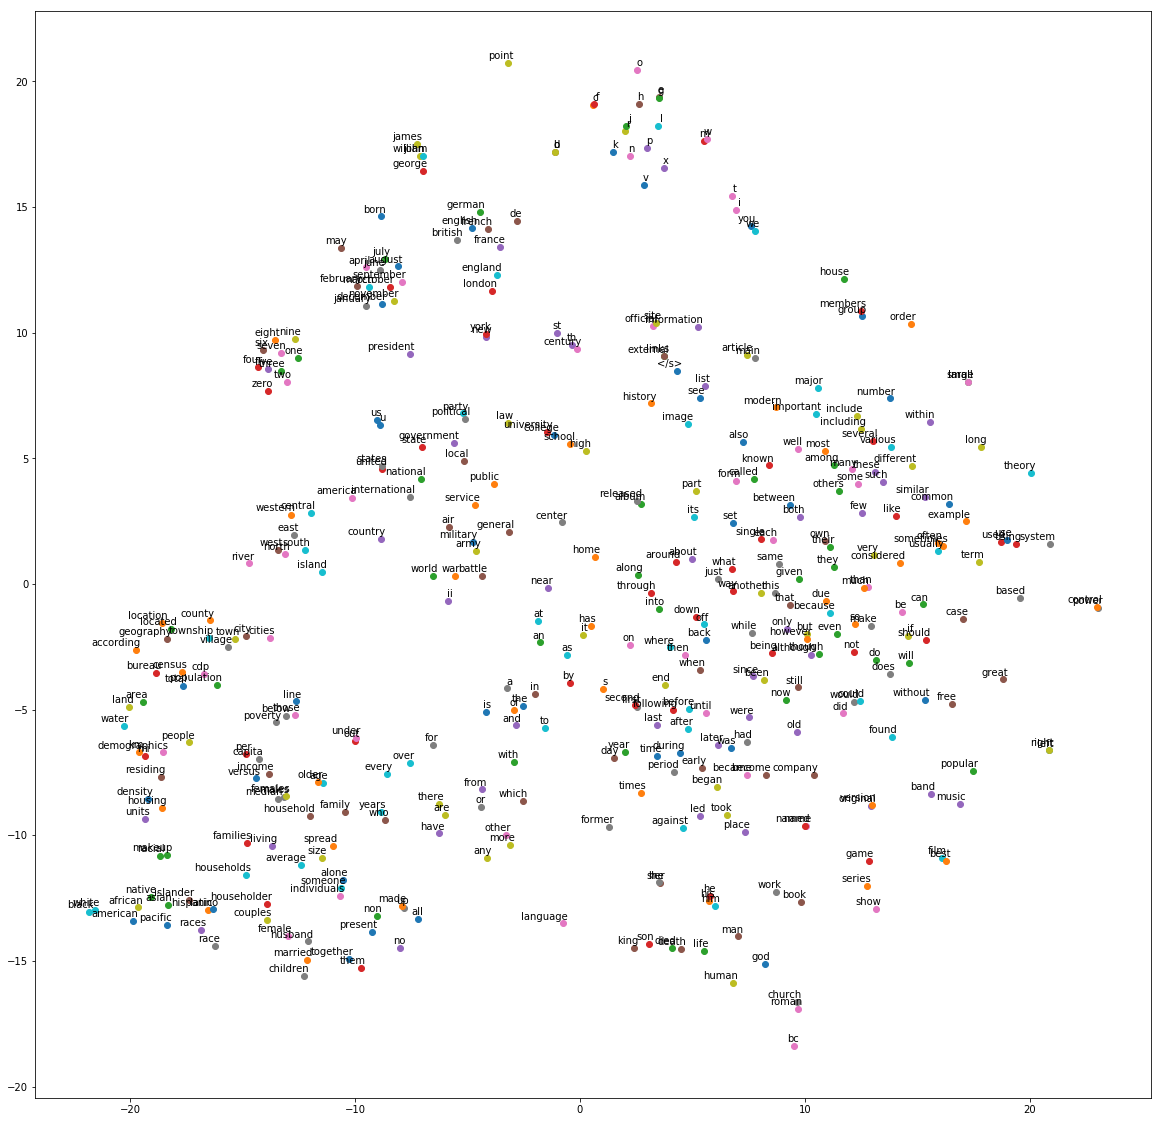

In [43]:
from matplotlib import pylab
%matplotlib inline

def plot(embeddings, labels):
    pylab.figure(figsize=(20,20))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

plot(two_d_embeddings, labels)

Running the code above might generate a plot like the one above. t-SNE and Word2Vec are stochastic, so although when you run the code the plot won’t look exactly like this, you can still see clusters of similar words such as above where 'british', 'american', 'french', 'english' are together, and 'military', 'army', 'war' and 'battle' are all together as well.

![tsne plot of embeddings](./tsne.png)

### Stop / Close the Endpoint (Optional)
Finally, we should delete the endpoint before we close the notebook.

In [44]:
sess.delete_endpoint(bt_endpoint.endpoint)